# Exercise 8 - Motion and Spectral Analysis

In [250]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.signal.windows import boxcar, hamming

# Data import and extraction:

importData = loadmat("./slowmotion_v2.mat")

iq = importData["iq"]

parameters = importData["pars"]
fps = parameters[0,0]["fps"].item()
f0 = parameters[0,0]["f0"].item()

depthStart = parameters[0,0]["depth_start"].item()
depthIncrement = parameters[0,0]["depth_inc"].item()
depthEnd = depthStart + depthIncrement*iq.shape[0]

zAxis = np.arange(depthStart, depthEnd, depthIncrement)*1e3
tAxis = np.arange(0, iq.shape[2]/fps, 1/fps)

centerBeam = iq[:,round(iq.shape[1]/2),:]

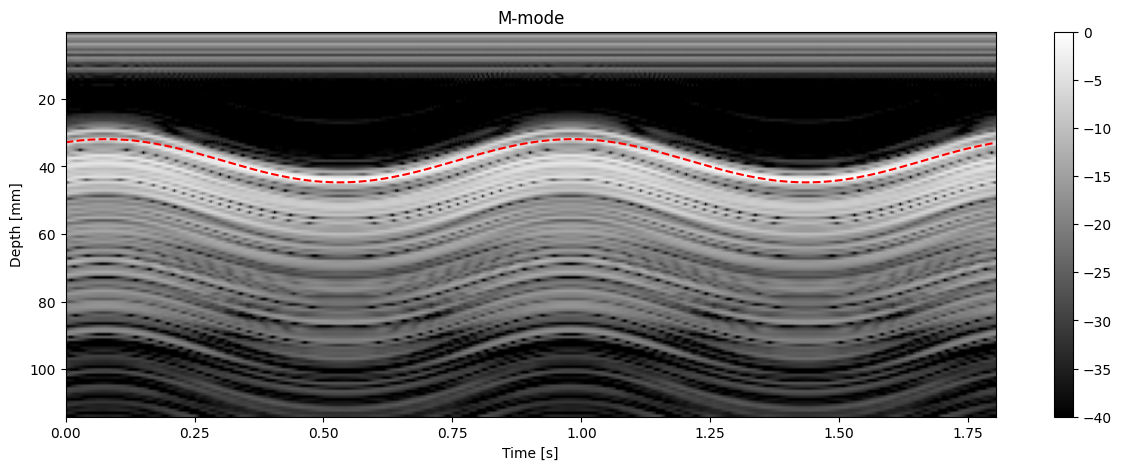

In [251]:
# M-mode vizualization:

mMode = np.abs(centerBeam)**2
mModeLog = 10*np.log10(mMode)
mModeLog -= np.max(mModeLog)

extent = np.array([tAxis[0], tAxis[-1], zAxis[-1], zAxis[0]])

plt.figure(figsize=(15,5))
plt.imshow(mModeLog, cmap="gray", extent=extent, aspect="auto", vmin=-40, vmax=0)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Depth [mm]")
plt.title("M-mode")

# Estimating motion parameters:
R = 6.4e-3
# L = 10e-2
t0 = 0.079
T = 0.905
z0 = 3.83e-2
r = -R * np.cos((2*np.pi*(tAxis-t0)) / T) + z0
rPeak = np.min(r)
# plt.plot([t0, t0 + T], [rPeak*1e3, rPeak*1e3], 'y-')
plt.plot(tAxis, r*1e3, 'r--')

plt.show()

## Observations (1.c)

The motions seen in the image is cyclic/periodic. Using trial and error I was able to estimate the parameters of the cyclic motion.
The analytical solution can be seen in the plot above (red dotted line), and it lines up well with the brighest part of the M-mode image.

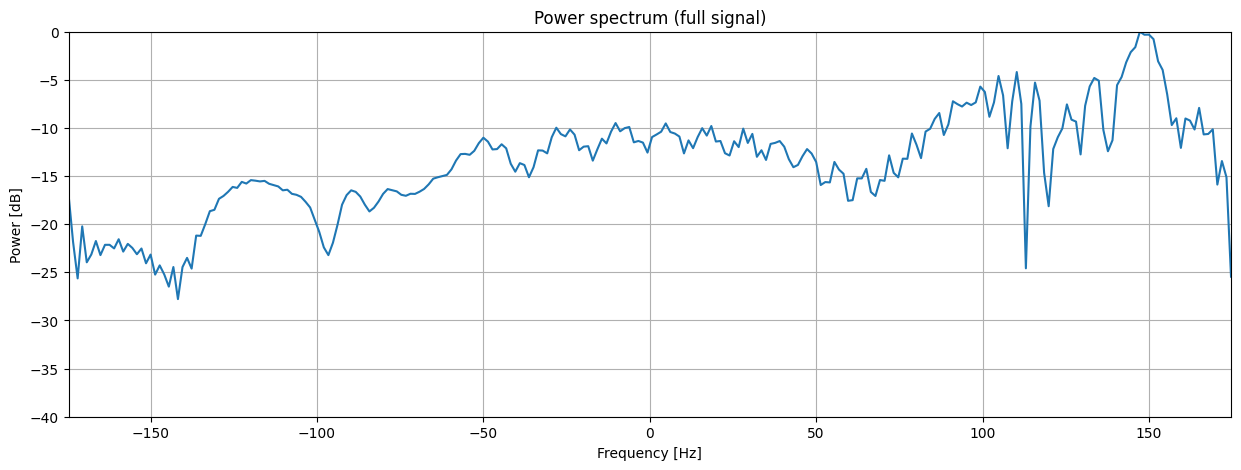

In [252]:
# Spectral analysis / Vizualizing the power spectrum:

def estimateSpectrum(signal, fps, N):
    spectrum = np.abs(np.fft.fft(signal, N))**2
    spectrum = np.fft.fftshift(spectrum)
    logSpectrum = 10*np.log10(spectrum)
    logSpectrum -= np.max(logSpectrum)
    freqs = np.linspace(-fps/2, fps/2, N)
    return freqs, logSpectrum

z0Index = np.argmin(np.abs((zAxis*1e-3) - z0))

freqs, fullSignalSpectrum = estimateSpectrum(centerBeam[z0Index], fps, 256)

plt.figure(figsize=(15,5))
plt.plot(freqs, fullSignalSpectrum)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")
plt.title("Power spectrum (full signal)")
plt.ylim([-40, 0])
plt.xlim([-fps/2, fps/2])
plt.grid()


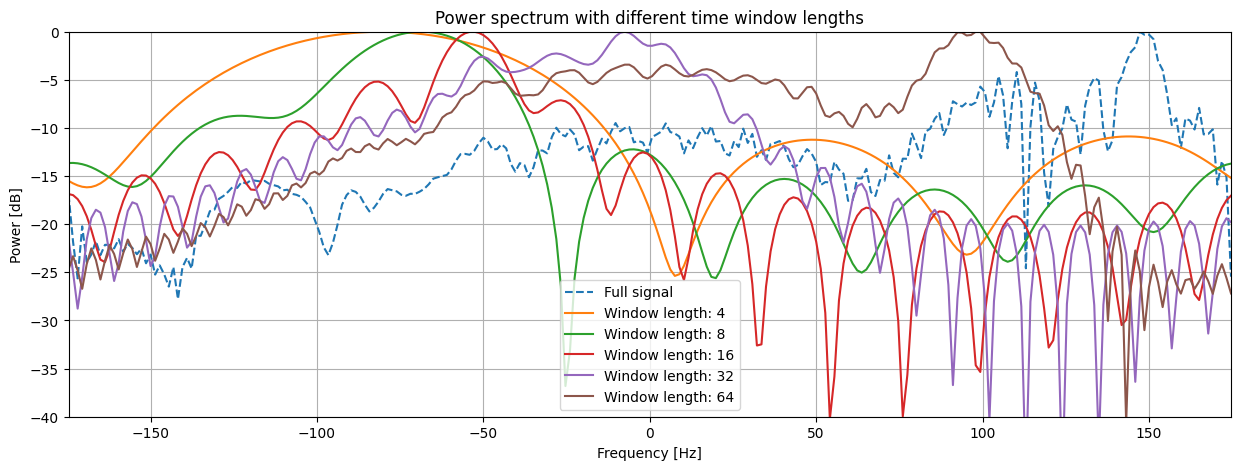

In [253]:
# Trying different time window lengths:

windowLengths = [4, 8, 16, 32, 64]
windowOffset = 0

plt.figure(figsize=(15,5))
plt.plot(freqs, fullSignalSpectrum, "--", label="Full signal")
for windowLength in windowLengths:
    signal = centerBeam[z0Index, np.arange(0, windowLength) + windowOffset]
    freqs, logSpectrum = estimateSpectrum(signal, fps, 256)
    plt.plot(freqs, logSpectrum, label=f"Window length: {windowLength}")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")
plt.title("Power spectrum with different time window lengths")
plt.ylim([-40, 0])
plt.xlim([-fps/2, fps/2])
plt.grid()
plt.legend()
plt.show()

## Observations (2.b)

The power spectrum based on the time-windowed does indeed have a more localized time distribution in general, but we see the effect is different for different window lengths.
For example, with a very short window of only 4 samples undersampling/aliasing effects means it's hard to glean any useful information from the power spectrum.
Interestingly, it's not only the power distribution (as in what ends up in the main lobe and what ends up as side lobes) that changes with the different window lengths, but also the location of the lobes all together.

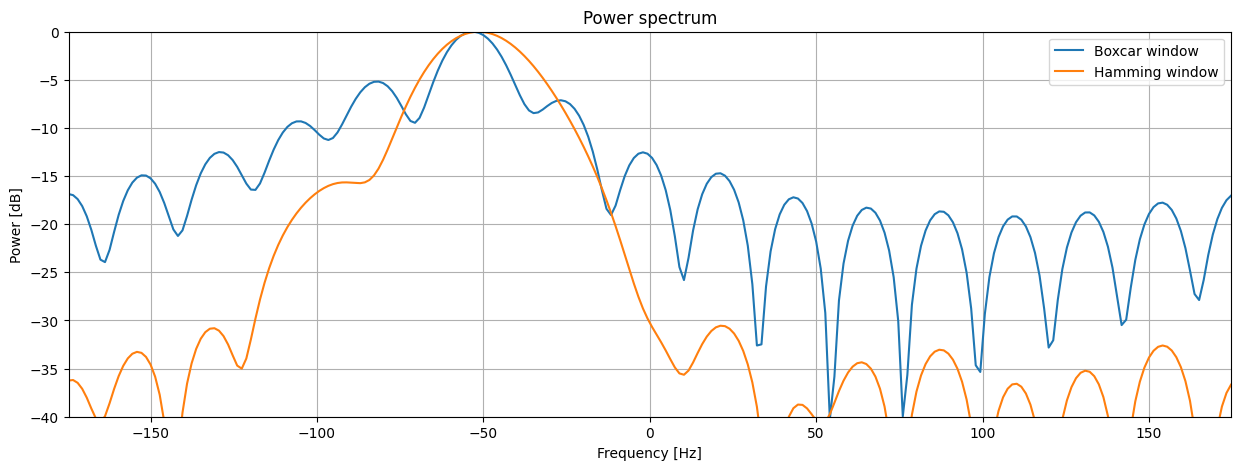

In [254]:
# Different window types:

windowLength = 16
Nfft = 256

signal = centerBeam[z0Index, np.arange(0, windowLength)]

boxcarSignal = signal * boxcar(windowLength)
hammingSignal = signal * hamming(windowLength)

freqs, boxcarSpectrum = estimateSpectrum(boxcarSignal, fps, Nfft)
_, hammingSpectrum = estimateSpectrum(hammingSignal, fps, Nfft)

plt.figure(figsize=(15,5))
plt.plot(freqs, boxcarSpectrum, label=f"Boxcar window")
plt.plot(freqs, hammingSpectrum, label=f"Hamming window")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")
plt.title("Power spectrum")
plt.ylim([-40, 0])
plt.xlim([-fps/2, fps/2])
plt.grid()
plt.legend()
plt.show()

## Observations (2.c)

As seen in the plot above, the side-lobes are much higher (compared to the main-) when using a boxcar window as opposed to a Hamming window.
This leads me to think the Hamming window is a better fit here.

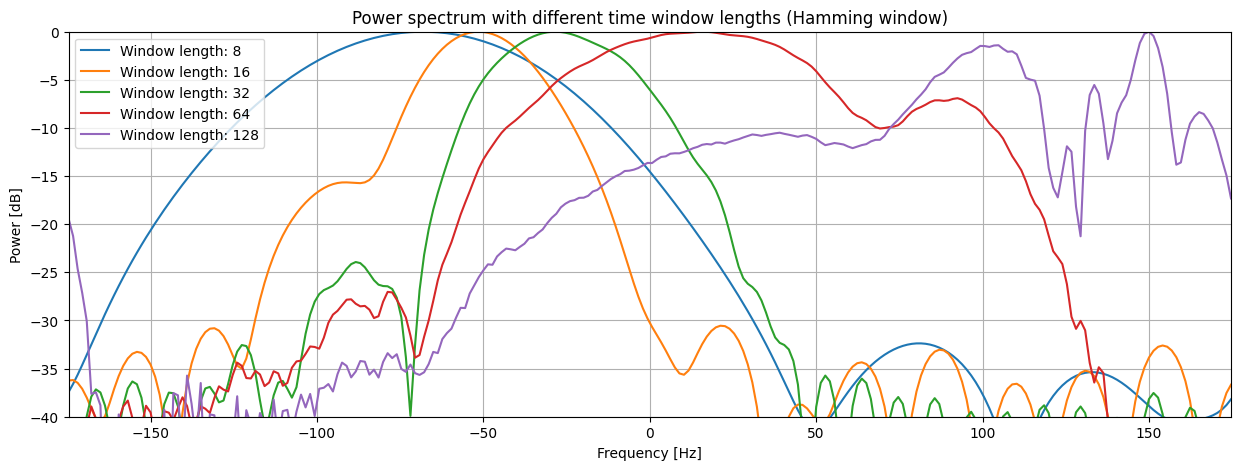

In [255]:
# Different time window lengths with Hamming window applied:

windowLengths = [8, 16, 32, 64, 128]

plt.figure(figsize=(15,5))
for windowLength in windowLengths:
    signal = centerBeam[z0Index, np.arange(0, windowLength)]
    signal *= hamming(windowLength)
    freqs, logSpectrum = estimateSpectrum(signal, fps, 256)
    plt.plot(freqs, logSpectrum, label=f"Window length: {windowLength}")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")
plt.title("Power spectrum with different time window lengths (Hamming window)")
plt.ylim([-40, 0])
plt.xlim([-fps/2, fps/2])
plt.grid()
plt.legend()
plt.show()

## Observations (2.d)

Based on the plots above I believe 8 or 16 samples works well as a suitable time window localization-wise, but the main lobe is quite wide for 8 samples.
The best choice would depend on the specific use case, but somewhere between 8 and 16 is a good place to start.

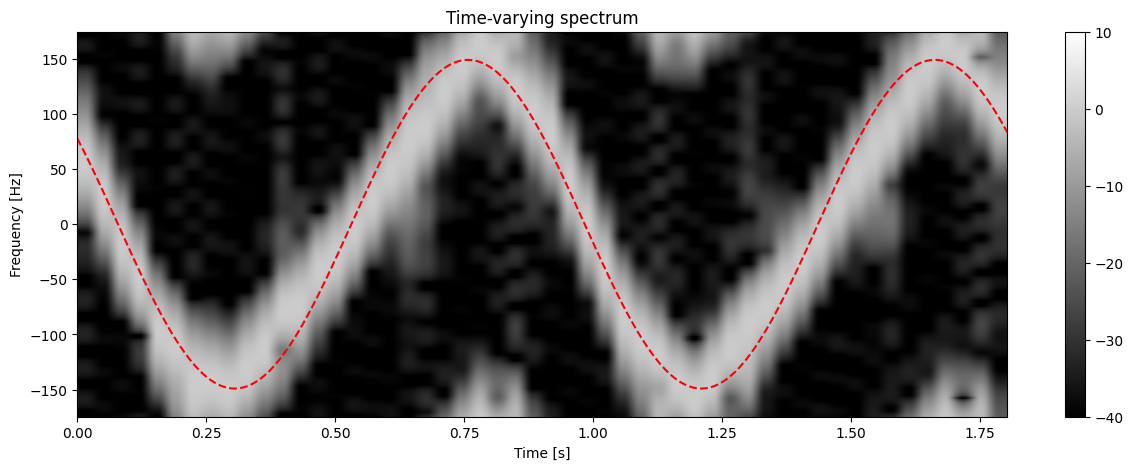

In [256]:
# Time-varying display of spectral analysis:

windowLength = 12
Nfft = 256

timeWindows = np.arange(0, len(tAxis) - windowLength + 1, windowLength)
spectra = np.zeros((Nfft, len(timeWindows)))

for k, w in enumerate(timeWindows):
    signal = centerBeam[z0Index, np.arange(0, windowLength) + w] * hamming(windowLength)
    freqs, logSpectrum = estimateSpectrum(signal, fps, Nfft)
    spectra[:, k] = logSpectrum

extent = np.array([tAxis[0], tAxis[-1], freqs[0], freqs[-1]])

c = 1490    # Speed of sound (water)
velocity = 2*np.pi * R/T * np.sin(2*np.pi*(tAxis-t0)/T)
frequency = -2 * f0 * velocity / c

plt.figure(figsize=(15,5))
plt.imshow(spectra, aspect='auto', cmap='gray', vmin=-40, vmax=10, extent=extent)
plt.plot(tAxis, frequency, "r--")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Time-varying spectrum")
plt.colorbar()
plt.show()


## Observations (2.e-f)

e)

Playing around with different window lengths we can clearly see the trade-off between time- and frequency-resolution. Depending on what we're trying to observe/measure, we might want to skew this trade-off one way or the other, but looking at a general "looks fine" criteria I suggest ~12 (seen above. Other examples attached).

The analytical solution somehwat fits, but it's not perfect. In the image above we see it lines up more or less, but might be cycling just a little bit too fast or at least be phase shifted back a little.